In [2]:
import os
import tempfile
import scanpy as sc
import scvi
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker
from scipy.io import mmread
import pandas as pd
import numpy as np
import anndata
import pymde

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
adata = anndata.read_h5ad('/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/Health_scanvi_1116.h5ad')

In [14]:
#metadata
meta_update = pd.read_csv("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_merge_qc_1115_intersectgene_mapct_meta.csv", index_col=0)

/tmp/slurmtmp.24735952/ipykernel_179164/1402622521.py:2: DtypeWarning: Columns (5,8,13,15,16,17,18,19,20,22,25,26,27,28,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_update = pd.read_csv("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_merge_qc_1115_intersectgene_mapct_meta.csv", index_col=0)


In [15]:
adata.obs = meta_update

In [16]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="purestudy_name",
    subset=True,
)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [18]:
#use scvi to integrate
scvi.model.SCVI.setup_anndata(adata, batch_key="purestudy_name")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 81/81: 100%|██████████| 81/81 [1:11:08<00:00, 51.64s/it, v_num=1, train_loss_step=919, train_loss_epoch=923]    

`Trainer.fit` stopped: `max_epochs=81` reached.


Epoch 81/81: 100%|██████████| 81/81 [1:11:08<00:00, 52.70s/it, v_num=1, train_loss_step=919, train_loss_epoch=923]


In [19]:
#evaluate latent representation
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
# cluster
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

In [21]:
# visualize
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/sit

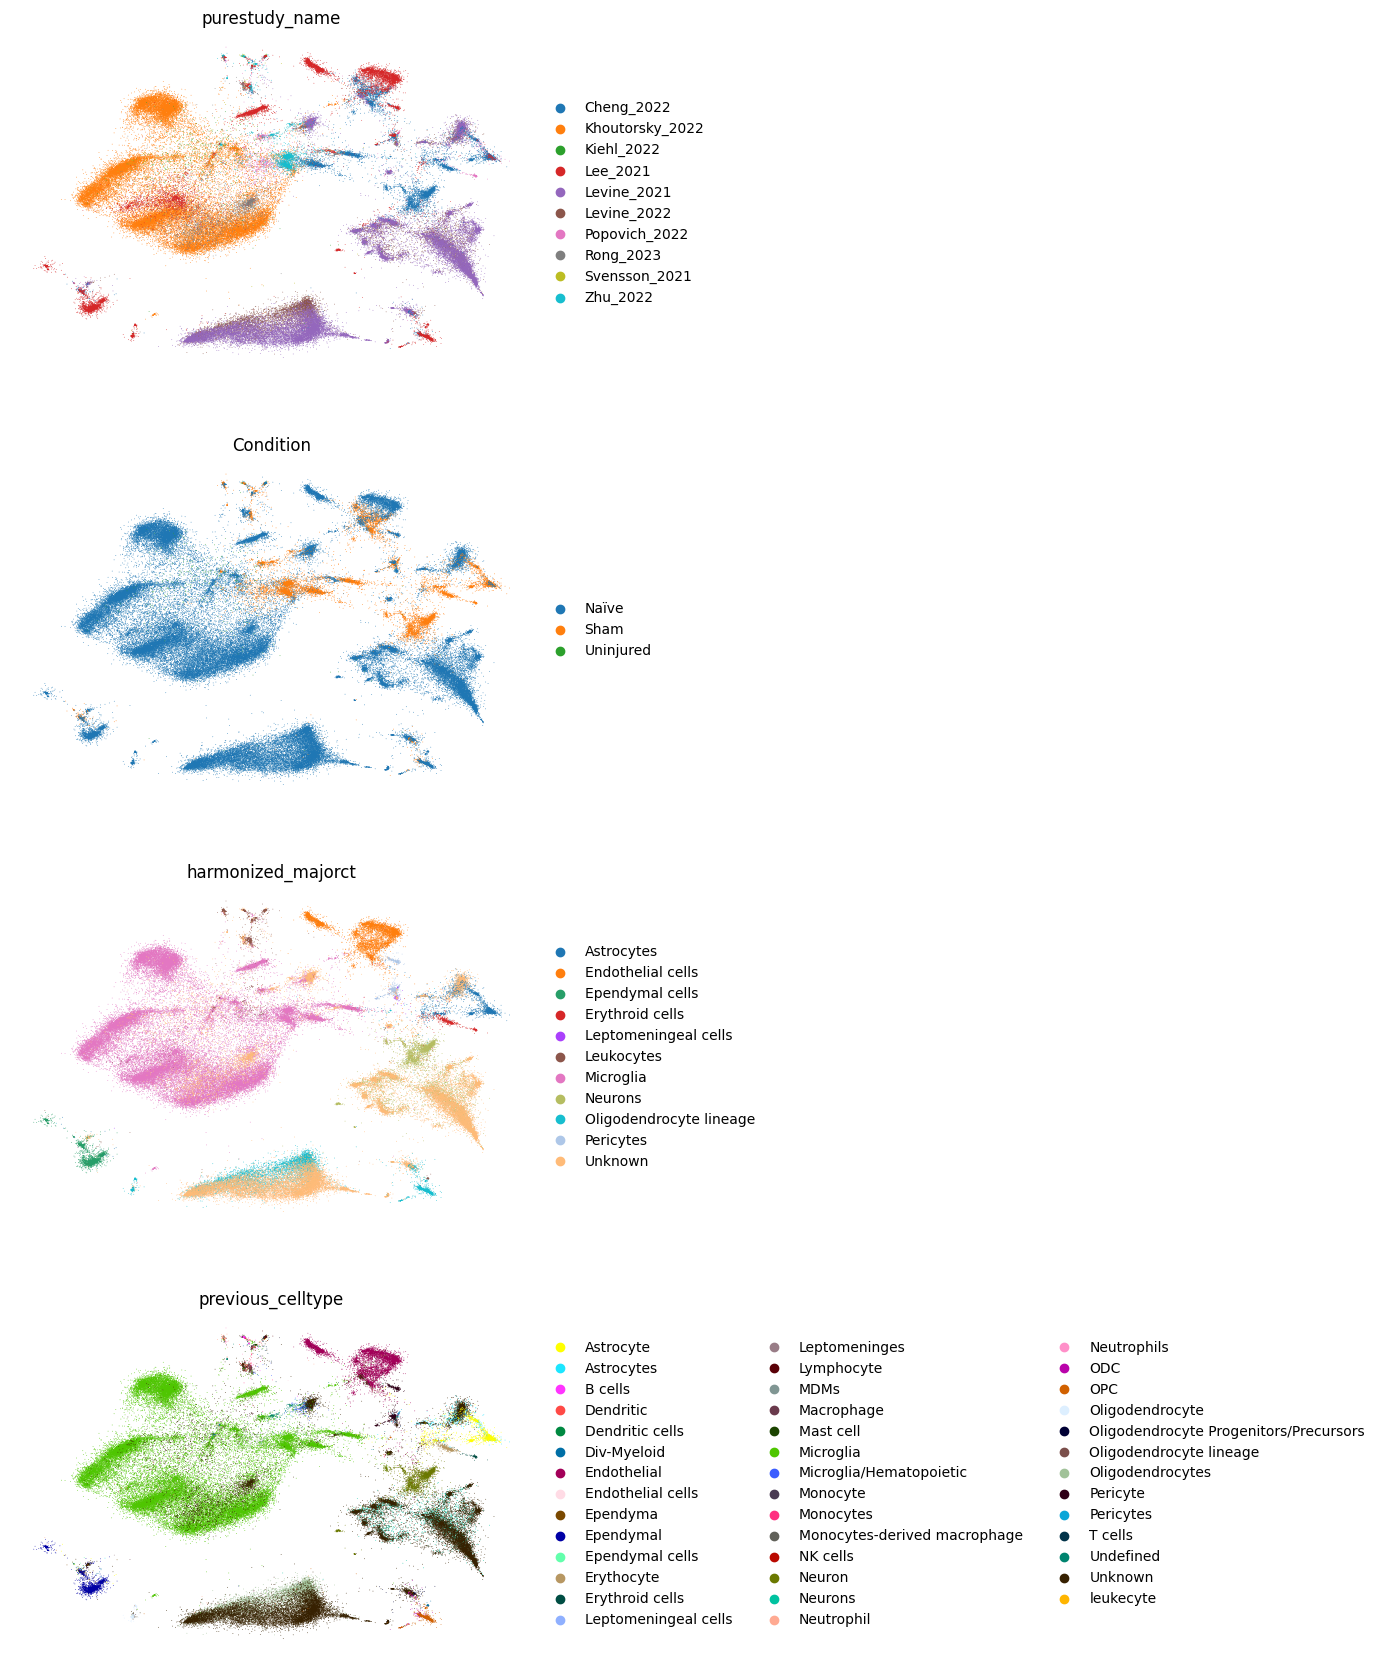

In [22]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["purestudy_name","Condition","harmonized_majorct","previous_celltype"],
    frameon=False,
    ncols=1,
)

In [20]:
adata.obs['harmonized_majorct'].drop_duplicates()

SCI00101_AAACCCAGTATGTCAC_1_1                  Microglia
SCI00101_AAACCCAGTCGACGCT_1_1                  Pericytes
SCI00101_AAACGCTGTATGTGTC_1_1                 Leukocytes
SCI00101_AAAGAACAGGCAGCTA_1_1          Endothelial cells
SCI00101_AAAGGATAGATACTGA_1_1                 Astrocytes
SCI00101_AAAGGATGTGAATATG_1_1            Ependymal cells
SCI00101_AACAGGGAGCCGAACA_1_1            Erythroid cells
SCI00101_AAGGTAACAACTCCCT_1_1       Leptomeningeal cells
SCI00101_AATGGAATCCGATAAC_1_1    Oligodendrocyte lineage
A-45_AAACCTGAGGGTATCG-1_1_1                      Neurons
E2_AAACCCAAGAGGACTC_1_1                          Unknown
Name: harmonized_majorct, dtype: object

In [23]:
# more accurate integration result when using scANVI if we have label
# scANVI should be initialized from a scVI model pre-traiAned on the same exact data.
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata, 
    labels_key="harmonized_majorct",
    unlabeled_category="Unknown",#scANVI can also be used with partially annotated dataset
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 20/20: 100%|██████████| 20/20 [21:54<00:00, 65.96s/it, v_num=1, train_loss_step=950, train_loss_epoch=979]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [21:54<00:00, 65.72s/it, v_num=1, train_loss_step=950, train_loss_epoch=979]


In [24]:
#retrieve the latent space
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [29]:
adata.obs["Prect_scANVI"] = scanvi_model.predict(adata)

In [25]:
#visualize the latent space as well as the inferred labels
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

In [28]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Study_name,Vendor,Species,Strain,Mice_number,Sex,Age,...,previous_celltype,previous_subcelltype,percent.mt,harmonized_majorct,nCount_integrated,nFeature_integrated,purestudy_name,_scvi_batch,_scvi_labels,leiden
SCI00101_AAACCCAGTATGTCAC_1_1,SCI00101,2115,1118,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,6,6,8
SCI00101_AAACCCAGTCGACGCT_1_1,SCI00101,1826,974,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Pericytes,Unknown,0.000000,Pericytes,0,0,Popovich_2022,6,9,19
SCI00101_AAACGAAAGCGACTGA_1_1,SCI00101,2038,1040,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,6,6,8
SCI00101_AAACGAAGTGACGCCT_1_1,SCI00101,3787,1586,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,6,6,8
SCI00101_AAACGAATCTGCTTAT_1_1,SCI00101,3804,1682,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGAATACAC_uninj_sample3,SCI00303,3896,1619,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Endothelial,Unknown,4.782609,Endothelial cells,0,0,Lee_2021,3,1,7
TTTGTTGCAGTACTAC_uninj_sample3,SCI00303,12280,3721,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Ependymal,Unknown,5.528310,Ependymal cells,0,0,Lee_2021,3,2,13
TTTGTTGGTAAGCAAT_uninj_sample3,SCI00303,7099,3029,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,OPC,Unknown,4.882640,Oligodendrocyte lineage,0,0,Lee_2021,3,8,20
TTTGTTGTCACCTGTC_uninj_sample3,SCI00303,9745,3028,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Endothelial,Unknown,4.623722,Endothelial cells,0,0,Lee_2021,3,1,7


/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/sit

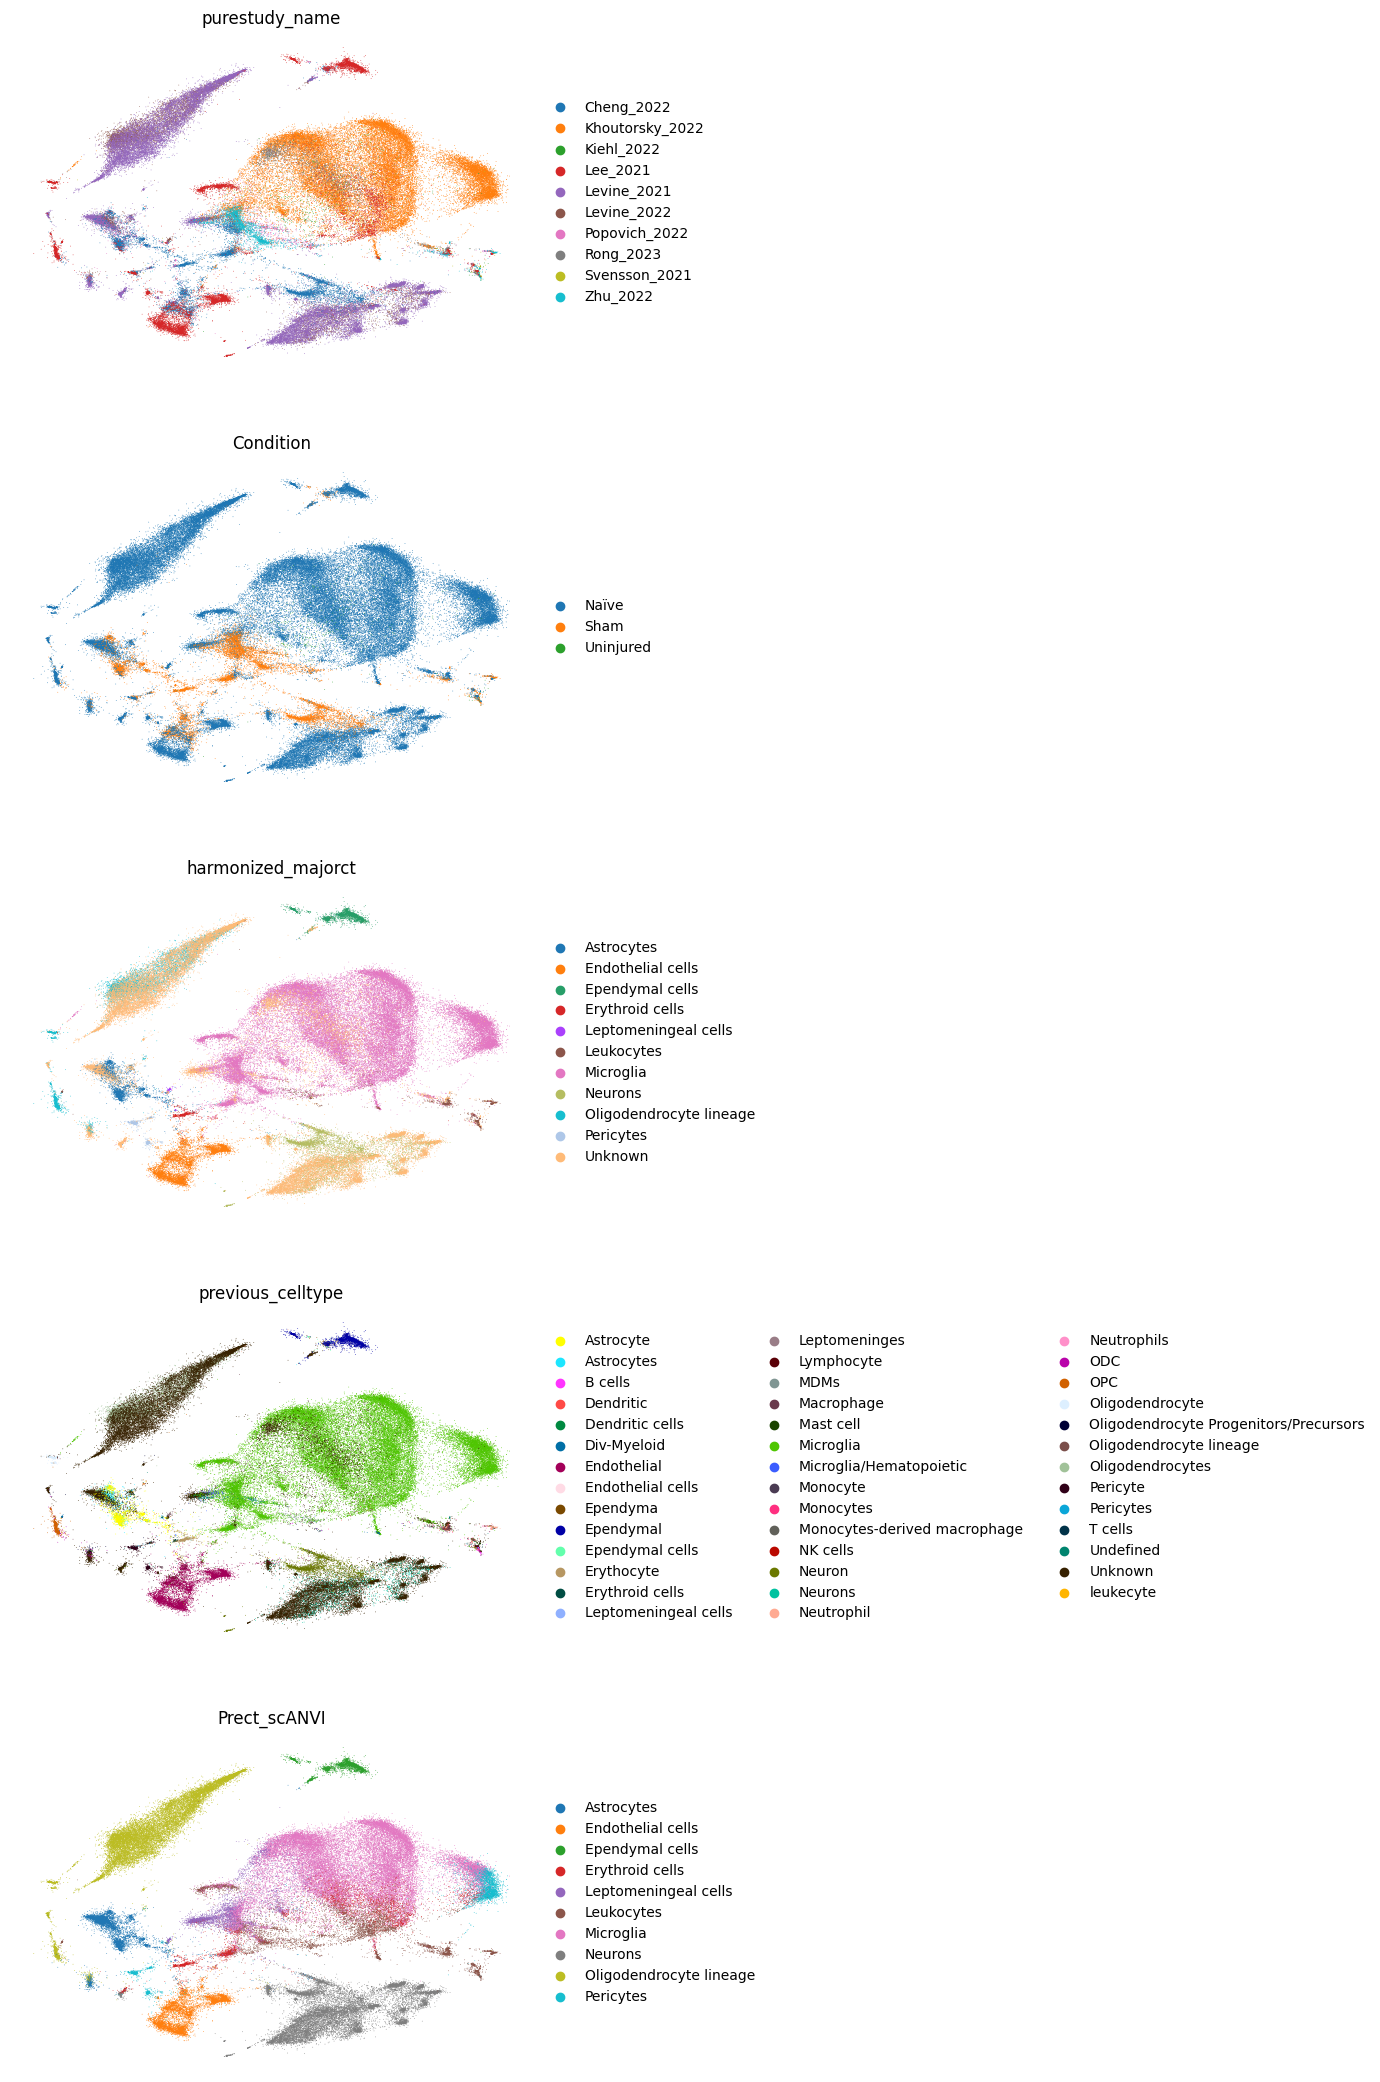

In [30]:
sc.pl.embedding(
    adata, basis=SCANVI_MDE_KEY, color=["purestudy_name","Condition","harmonized_majorct","previous_celltype","Prect_scANVI"], ncols=1, frameon=False
)

In [7]:
adata

AnnData object with n_obs × n_vars = 98359 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Study_name', 'Vendor', 'Species', 'Strain', 'Mice_number', 'Sex', 'Age', 'Tissue', 'Spinal_cord_removed_level', 'Sample_location_description', 'Condition', 'Meninges_removal', 'Perfusion', 'Spinal_cord_process_workflow', 'Injury_location_(level)', 'Injury_severity', 'Treatment', 'Time_post_injury_(dpi)', 'Cell_type_description', 'Fresh_or_frozen', 'Sequencing_types', 'Dissociation', 'Sequencing_technology', 'Sequencing_platform', 'Cellranger_version', 'Reference_genome', 'Genome_annotation_databases', 'Number_of_cells/spots', 'Number_of_genes', 'Gene_naming_format', 'Cell_type_annotation', 'previous_celltype', 'previous_subcelltype', 'percent.mt', 'harmonized_majorct', 'nCount_integrated', 'nFeature_integrated', 'purestudy_name', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable

In [41]:
adata.obs['Mice_number'] = adata.obs['Mice_number'].astype(str)
#save
adata.write('/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_scanvi_1116_comblee.h5ad')

... storing 'Mice_number' as categorical


In [3]:
adata = anndata.read_h5ad("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_scanvi_1116_comblee.h5ad")

In [32]:
#add pca
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="purestudy_name")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:484: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA col

In [46]:
#SCANVI_LATENT_KEY = "X_scANVI"
#SCANVI_MDE_KEY = "X_scANVI_MDE"
#SCVI_LATENT_KEY = "X_scVI"
#SCVI_MDE_KEY = "X_scVI_MDE"

In [33]:
from harmony import harmonize
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="purestudy_name")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [34]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
batch_cats = adata.obs.purestudy_name.cat.categories
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.purestudy_name == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.purestudy_name == b] = liger_data.adata_list[i].obsm["H_norm"]

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [10:33<00:00, 21.12s/it]


In [45]:
bdata

AnnData object with n_obs × n_vars = 98359 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Study_name', 'Vendor', 'Species', 'Strain', 'Mice_number', 'Sex', 'Age', 'Tissue', 'Spinal_cord_removed_level', 'Sample_location_description', 'Condition', 'Meninges_removal', 'Perfusion', 'Spinal_cord_process_workflow', 'Injury_location_(level)', 'Injury_severity', 'Treatment', 'Time_post_injury_(dpi)', 'Cell_type_description', 'Fresh_or_frozen', 'Sequencing_types', 'Dissociation', 'Sequencing_technology', 'Sequencing_platform', 'Cellranger_version', 'Reference_genome', 'Genome_annotation_databases', 'Number_of_cells/spots', 'Number_of_genes', 'Gene_naming_format', 'Cell_type_annotation', 'previous_celltype', 'previous_subcelltype', 'percent.mt', 'harmonized_majorct', 'nCount_integrated', 'nFeature_integrated', 'purestudy_name', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable

In [36]:
#evaluate integration performance
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
#adata.X = adata.X.astype(float)
bm = Benchmarker(
    adata,
    batch_key="purestudy_name",
    label_key="harmonized_majorct",
    embedding_obsm_keys=["Unintegrated", "LIGER", "Harmony", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=5,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|

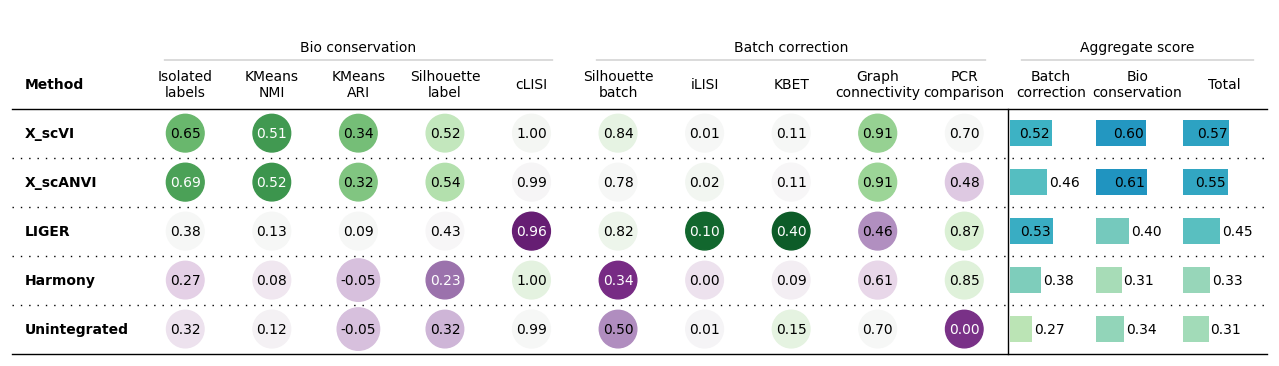

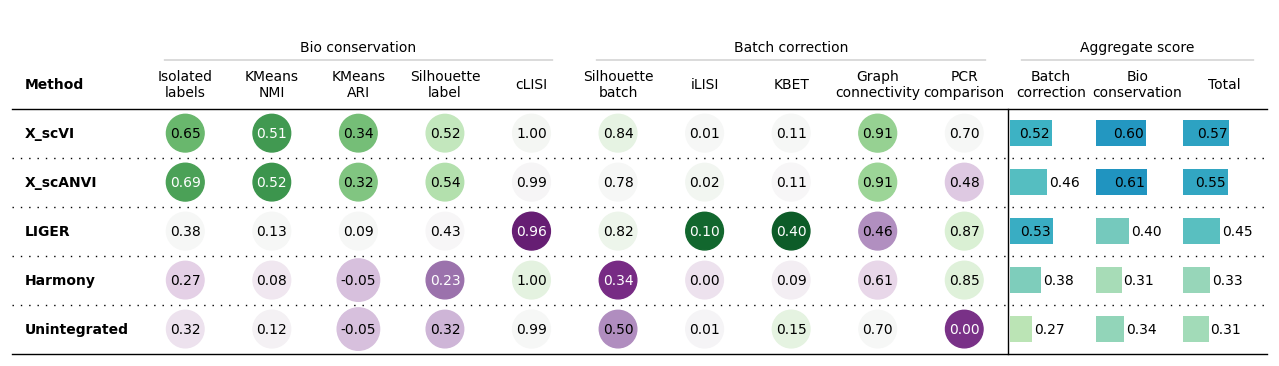

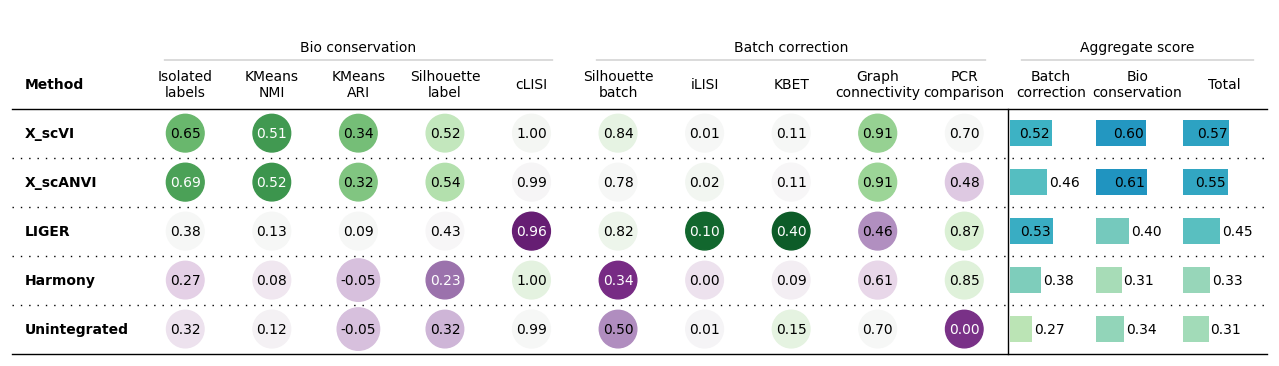

In [40]:
bm.plot_results_table(min_max_scale=False)

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
adata.obs['Mice_number'] = adata.obs['Mice_number'].astype(str)
#save
adata.write('/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_scanvi_1116_comblee.h5ad')